In [6]:
# Import necessary packages & set-up plotting aesthetics

import numpy as np 
import pylab
import pandas as pd
import lal
from scipy.stats import gaussian_kde
import importlib
import json

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import seaborn as sns
cp = sns.color_palette('muted')
cp2 = sns.color_palette('pastel')

import sys
sys.path.append('../../../scripts/')
from utils.io import load_posterior_samples

### Load in posterior samples

Real data, max(P) injection,  max(L) injection, and 10 fair draw injections

In [1]:
# date of runs
date = '100923'

# the cuts we look at 
cuts_float = np.arange(-3, 4.5, 0.5)
cuts = [int(c) if c.is_integer() else c for c in cuts_float]

td_samples = {}

# load the real data results
realData_runname = 'GW190521_realData'
td_samples[realData_runname] = load_posterior_samples(date, realData_runname, cuts[0], cuts[-1]) 

# load the maxP injection results 
maxP_inj_runname = 'injection_GW190521_maxP'
td_samples[maxP_inj_runname] = load_posterior_samples(date, maxP_inj_runname, 0, 0) 

# load the maxL injection results 
date2 = '101123'
maxL_inj_runname = 'injection_GW190521_maxL'
td_samples[maxL_inj_runname] = load_posterior_samples(date2, maxL_inj_runname, 0, 0) 

# load the fair draw injection results 
for i in range (10):
    fair_draw_runname = f'injection_GW190521_fairdraw_{int(i)}'
    td_samples[fair_draw_runname] = load_posterior_samples(date2, fair_draw_runname, 0, 0) 

could not find /home/simona.miller/time-domain-gw-inference/data/output/100923_GW190521_realData_pre_-3cycles.dat
could not find /home/simona.miller/time-domain-gw-inference/data/output/100923_GW190521_realData_pre_-2.5cycles.dat
could not find /home/simona.miller/time-domain-gw-inference/data/output/100923_GW190521_realData_pre_-2cycles.dat
could not find /home/simona.miller/time-domain-gw-inference/data/output/101123_injection_GW190521_maxL_pre_0cycles.dat
could not find /home/simona.miller/time-domain-gw-inference/data/output/101123_injection_GW190521_maxL_post_0cycles.dat
could not find /home/simona.miller/time-domain-gw-inference/data/output/101123_injection_GW190521_fairdraw_0_pre_0cycles.dat
could not find /home/simona.miller/time-domain-gw-inference/data/output/101123_injection_GW190521_fairdraw_0_post_0cycles.dat
could not find /home/simona.miller/time-domain-gw-inference/data/output/101123_injection_GW190521_fairdraw_1_pre_0cycles.dat
could not find /home/simona.miller/time-d

In [2]:
# Load injected parameters
injected_params = {}

with open('../../input/injection_params/GW190521_maxP.json','r') as jf:
    injected_params['injection_GW190521_maxP'] = json.load(jf)
    
with open('../../input/injection_params/GW190521_maxL.json','r') as jf:
    injected_params['injection_GW190521_maxL'] = json.load(jf)
    
for i in range (10):
    key = f'GW190521_fairdraw_{int(i)}'
    with open(f'../../input/injection_params/{key}.json','r') as jf:
        injected_params['injection_'+key] = json.load(jf)

### Plot posteriors

In [3]:
params_to_plot = ['mtotal', 'q', 'chieff', 'chip', 'dist']
params_labels = {
    'mtotal':'M', 
    'q':'q', 
    'chieff':'\chi_\mathrm{eff}',
    'chip':'\chi_p', 
    'dist':'d_L'
}
injs_kws ={
    'mtotal':'total_mass',
    'q':'mass_ratio', 
    'chieff':'chi_eff',
    'chip':'chi_p', 
    'dist':'luminosity_distance'
}

kws = {
    f'{realData_runname} pre':dict(color='C0', histtype='step', density=True, label=r'real pre-$t_c$'), 
    f'{realData_runname} post':dict(color='C1', histtype='step', density=True, label=r'real post-$t_c$'), 
    f'{realData_runname} full':dict(color='k', histtype='step', density=True, label='real'), 
    
    f'{maxP_inj_runname} pre':dict(color='C0', ls='--', histtype='step', density=True, label=r'inj pre-$t_c$'), 
    f'{maxP_inj_runname} post':dict(color='C1', ls='--', histtype='step', density=True, label=r'inj post-$t_c$'), 
    f'{maxP_inj_runname} full':dict(color='k', ls='--', histtype='step', density=True, label='inj maxP'), 
    
    f'{maxL_inj_runname} full':dict(color='crimson', ls='--', histtype='step', density=True, label='inj maxL'), 
    
    'prior':dict(color='gray', ls=':', histtype='step', density=True, label='prior')
}

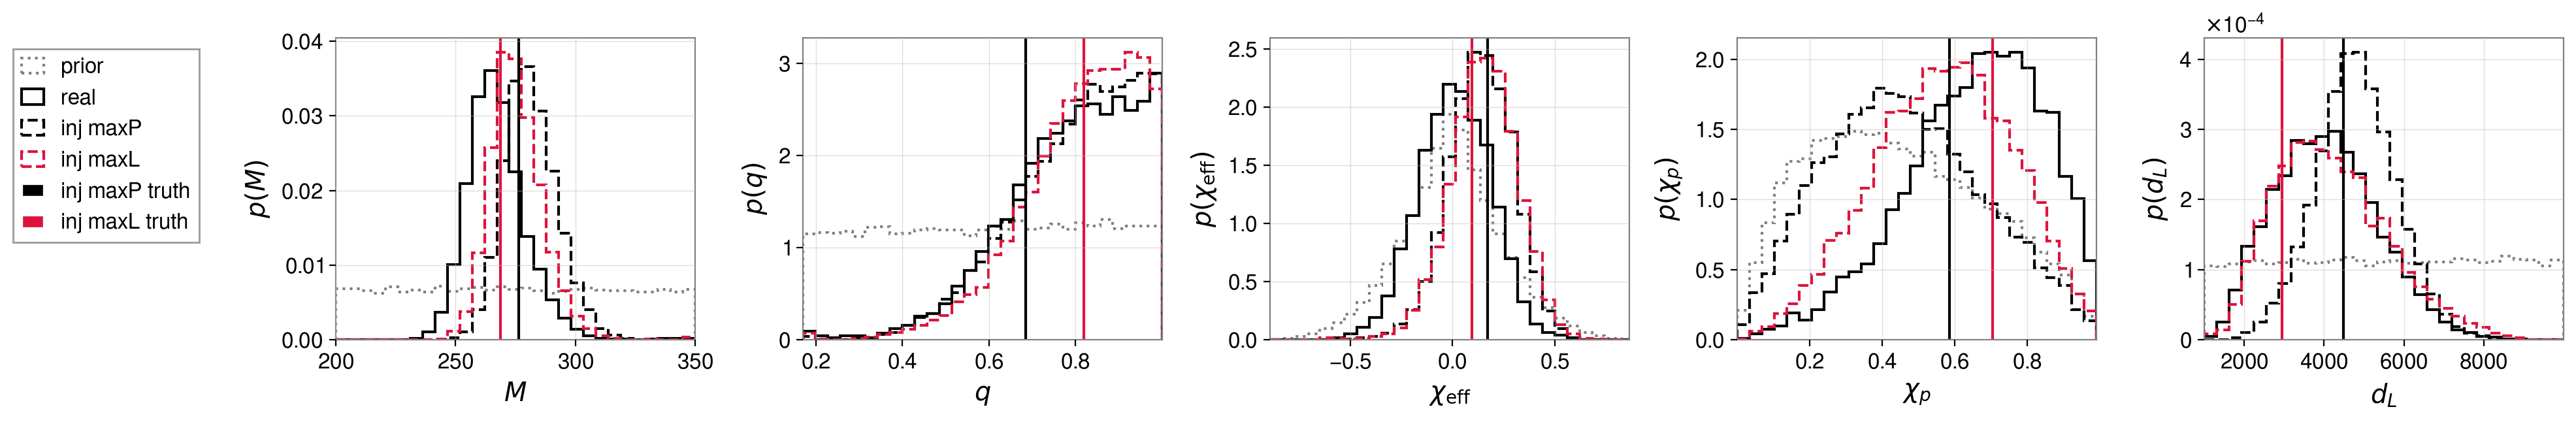

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=len(params_to_plot), figsize=(22, 3))

for i, p in enumerate(params_to_plot): 

    prior_samps = td_samples[realData_runname]['prior'][p]
    if p=='mtotal': 
        bounds = [200, 350]
    else:
        bounds = [min(prior_samps), max(prior_samps)]
    bins = np.linspace(*bounds, 30)

    axes[i].hist(prior_samps, **kws['prior'], bins=bins, lw=1.5)

    for name in [realData_runname, maxP_inj_runname, maxL_inj_runname]:

        full_samps = td_samples[name]['full'][p]
        axes[i].hist(full_samps, **kws[f'{name} full'], bins=bins, lw=1.5)

    
    for j, inj in enumerate(['maxP', 'maxL']):
        
        value = injected_params[f'injection_GW190521_{inj}'][injs_kws[p]]
        
        axes[i].axvline(value, color=kws[f'injection_GW190521_{inj} full']['color'], label=f'inj {inj} truth')
        
    axes[i].set_xlim(*bounds)
    axes[i].set_xlabel(fr'${params_labels[p]}$')
    axes[i].set_ylabel(fr'$p({params_labels[p]})$')
    axes[i].grid(':', color='silver', alpha=0.5)

axes[0].legend(bbox_to_anchor=(-0.35, 1), loc="upper right")
plt.subplots_adjust(wspace=0.3)
plt.show()

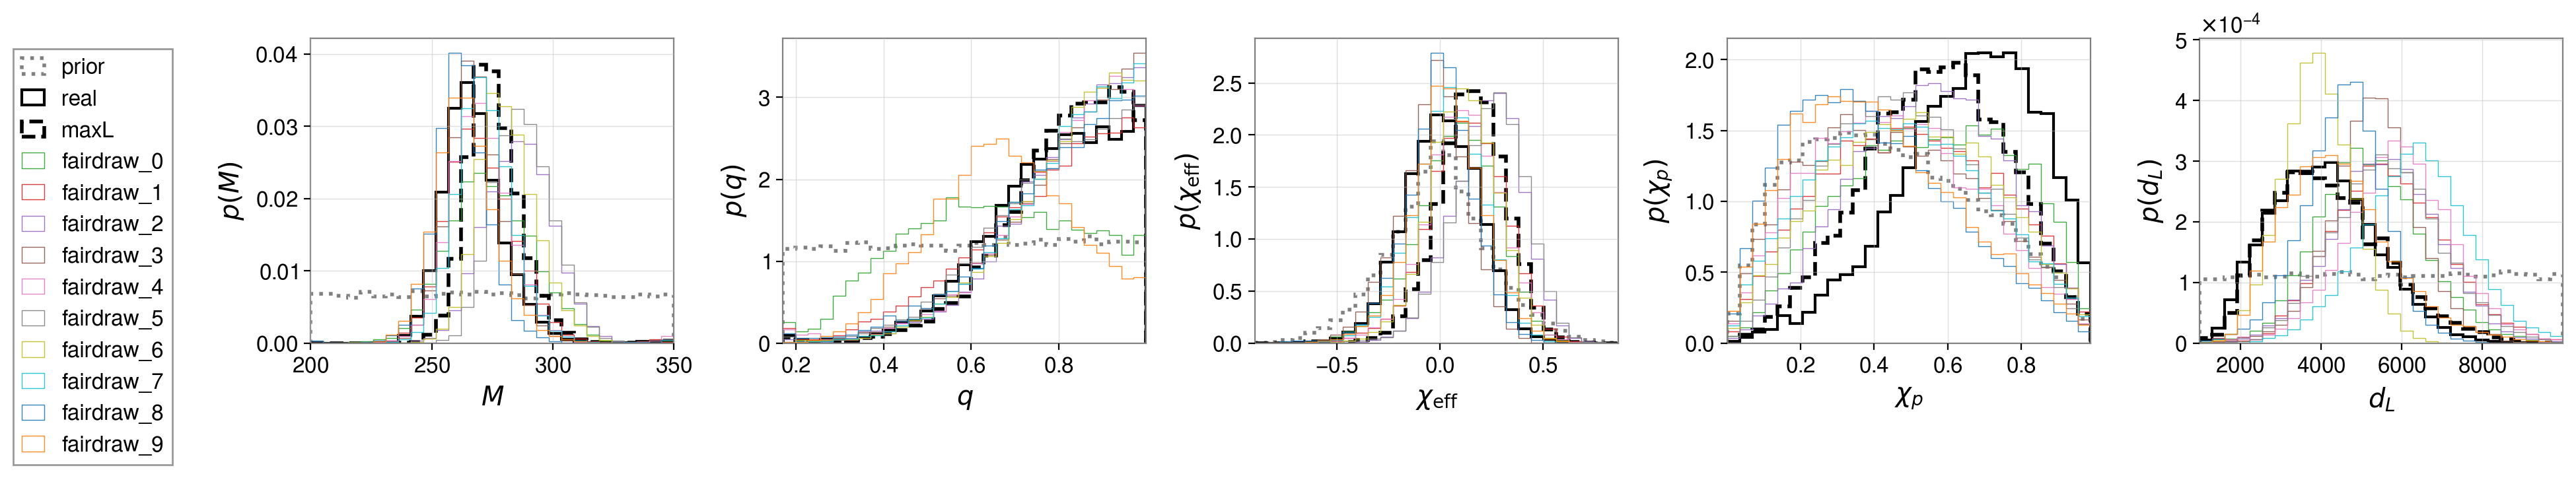

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=len(params_to_plot), figsize=(22, 3))

for i, p in enumerate(params_to_plot): 

    prior_samps = td_samples[realData_runname]['prior'][p]
    if p=='mtotal': 
        bounds = [200, 350]
    else:
        bounds = [min(prior_samps), max(prior_samps)]
    bins = np.linspace(*bounds, 30)

    axes[i].hist(prior_samps, **kws['prior'], bins=bins, lw=2)
    
    real_samps = td_samples[realData_runname]['full'][p]
    axes[i].hist(real_samps, **kws[f'{realData_runname} full'], bins=bins, lw=1.5)

    for j, name in enumerate(injected_params.keys()):
        
        if 'maxP' not in name:

            full_samps = td_samples[name]['full'][p]

            color, alpha, lw, ls = ['k', 1, 2, '--'] if 'maxL' in name else [f'C{j}', 0.9, 0.5, '-']

            ls = '--' if 'maxL' in name else '-'

            axes[i].hist(full_samps, bins=bins, histtype='step', density=True, color=color, alpha=alpha, 
                         lw=lw, ls=ls, label=name.split('injection_GW190521_')[-1])
        
    axes[i].set_xlim(*bounds)
    axes[i].set_xlabel(fr'${params_labels[p]}$')
    axes[i].set_ylabel(fr'$p({params_labels[p]})$')
    axes[i].grid(':', color='silver', alpha=0.5)

axes[0].legend(bbox_to_anchor=(-0.35, 1), loc="upper right")
plt.subplots_adjust(wspace=0.3)
plt.show()